# Backtesting a simple strategy on ETH

This time I want to use real data, not the testnet :)

## Download and prepare the data for backtesting

In [1]:
import pandas as pd
import numpy as np


I have encrypted my API login info, so I just load and use them without revealing anything :)

In [2]:
path1 = "/Users/leonardoplacidi/Desktop/BacktestingTrade/Python4Finance/encrypted/bybit_sub_secret.key"
path2 = "/Users/leonardoplacidi/Desktop/BacktestingTrade/Python4Finance/encrypted/bybit_sub_encrypted_keys.txt"

In [3]:
from pybit.unified_trading import HTTP
from encrypted.encryption import load_keys

api_key, api_secret = load_keys(path1, path2)
session = HTTP(
    testnet=False,
    api_key= api_key,
    api_secret = api_secret,
)

print(session.get_server_time())

{'retCode': 0, 'retMsg': 'OK', 'result': {'timeSecond': '1716698442', 'timeNano': '1716698442831447965'}, 'retExtInfo': {}, 'time': 1716698442831}


Now load ETH data

In [4]:
from utils.convert_datetime import convert_to_timestamp
start_date = convert_to_timestamp("2024-01-01")
end_date = convert_to_timestamp("2024-5-25")

In [5]:
def get_data_with_volume_bybit(session, symbol, start_date, end_date, interval = "D", category = "linear", limit = 200):
    
    data = session.get_kline(
    category=category,
    symbol=symbol,
    interval= interval,
    start = start_date,
    end = end_date,
    limit= limit,
    )


    # Convert list to DataFrame
    columns = ['startTime', 'openPrice', 'highPrice', 'lowPrice', 'closePrice', 'volume', 'turnover']
    df = pd.DataFrame(data["result"]['list'], columns=columns)

    # Adding a new column for the symbol
    df['symbol'] = symbol

    # Convert startTime to datetime and prices to floats
    df['startTime'] = pd.to_datetime(df['startTime'].astype(float), unit='ms')
    for col in ['openPrice', 'highPrice', 'lowPrice', 'closePrice', 'volume', 'turnover']:
        df[col] = df[col].astype(float)

    # Sort the DataFrame by startTime in descending order
    df = df.sort_values(by='startTime', ascending=False)
    
    print(df.head())
    
    return df


def get_data_OI_bybit(session, symbol, start_date, end_date, interval = "1d", category = "linear", limit = 200):
    
    data_OI = session.get_open_interest(
    category = category,
    symbol = symbol,
    intervalTime = interval,
    startTime = start_date,
    endTime = end_date,
    limit = limit,
    )


    # Convert list to DataFrame
    columns = ['openInterest', 'timestamp']
    df = pd.DataFrame(data_OI["result"]['list'], columns=columns)


    # Convert startTime to datetime and prices to floats
    df['startTime'] = pd.to_datetime(df['timestamp'].astype(float), unit='ms')
    df['openInterest'] = df['openInterest'].astype(float)
    # Sort the DataFrame by startTime in descending order
    df = df.sort_values(by='startTime', ascending=False)

    # Display the DataFrame
    print(df.head())
    return df

In [6]:
symbol = "ETHUSD"
df1 = get_data_with_volume_bybit(session, symbol, start_date, end_date, interval = "D", category = "linear", limit = 200)
df2 = get_data_OI_bybit(session, symbol, start_date, end_date, interval = "1d", category = "linear", limit = 200)

df_ETH = pd.merge(df1, df2[['startTime', 'openInterest']], on='startTime', how='inner')

df_ETH.to_csv('/Users/leonardoplacidi/Desktop/BacktestingTrade/Python4Finance/data/Bybit_ETH_for_backtesting.csv', index=False) 

   startTime  openPrice  highPrice  lowPrice  closePrice       volume  \
0 2024-05-24    3784.15    3832.05   3627.05     3728.60  268476729.0   
1 2024-05-23    3740.50    3951.15   3507.05     3784.15  998759848.0   
2 2024-05-22    3793.00    3815.35   3654.85     3740.50  287634099.0   
3 2024-05-21    3665.30    3844.85   3627.70     3793.00  375445948.0   
4 2024-05-20    3069.10    3699.90   3046.05     3665.30  439138274.0   

        turnover  symbol  
0   72224.501005  ETHUSD  
1  263611.939310  ETHUSD  
2   76947.502901  ETHUSD  
3  100420.642724  ETHUSD  
4  130692.238330  ETHUSD  
   openInterest      timestamp  startTime
0   338357319.0  1716508800000 2024-05-24
1   349971866.0  1716422400000 2024-05-23
2   348212671.0  1716336000000 2024-05-22
3   342281637.0  1716249600000 2024-05-21
4   315706080.0  1716163200000 2024-05-20


In [7]:
df_ETH.head()

,startTime,openPrice,highPrice,lowPrice,closePrice,volume,turnover,symbol,openInterest
0,2024-05-24,3784.15,3832.05,3627.05,3728.60,268476729.0,72224.501005,ETHUSD,338357319.0
1,2024-05-23,3740.50,3951.15,3507.05,3784.15,998759848.0,263611.939310,ETHUSD,349971866.0
2,2024-05-22,3793.00,3815.35,3654.85,3740.50,287634099.0,76947.502901,ETHUSD,348212671.0
3,2024-05-21,3665.30,3844.85,3627.70,3793.00,375445948.0,100420.642724,ETHUSD,342281637.0
4,2024-05-20,3069.10,3699.90,3046.05,3665.30,439138274.0,130692.238330,ETHUSD,315706080.0


In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc

def visualize_df_with_vol_oi(df, saving_path):
    # Prepare data for candlestick chart
    df['date'] = mdates.date2num(df['startTime'])
    ohlc = df[['date', 'openPrice', 'highPrice', 'lowPrice', 'closePrice']].copy()
    volume = df[['date', 'volume']].copy()
    open_interest = df[['date', 'openInterest']].copy()

    # Creating subplots with shared x-axis
    fig, (ax, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1, 1]})

    # Plot candlestick chart
    candlestick_ohlc(ax, ohlc.values, width=0.5, colorup='green', colordown='red', alpha=1)
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.set_ylabel('Price')

    # Plot volume below candlestick chart
    ax2.bar(volume['date'], volume['volume'], color='blue', width=0.5)
    ax2.set_ylabel('Volume')

    # Plot open interest below volume chart
    ax3.bar(open_interest['date'], open_interest['openInterest'], color='gray', width=0.5)
    ax3.set_ylabel('Open Interest')

    # Formatting the shared x-axis
    plt.xticks(rotation=45)
    plt.subplots_adjust(hspace=0)  # Reduce space between plots

    # Set the title for the entire figure
    fig.suptitle(f"Candlestick Chart for {df['symbol'][0]}", fontsize=16)
    
    fig.savefig(saving_path)

    # Display the plot
    plt.show()

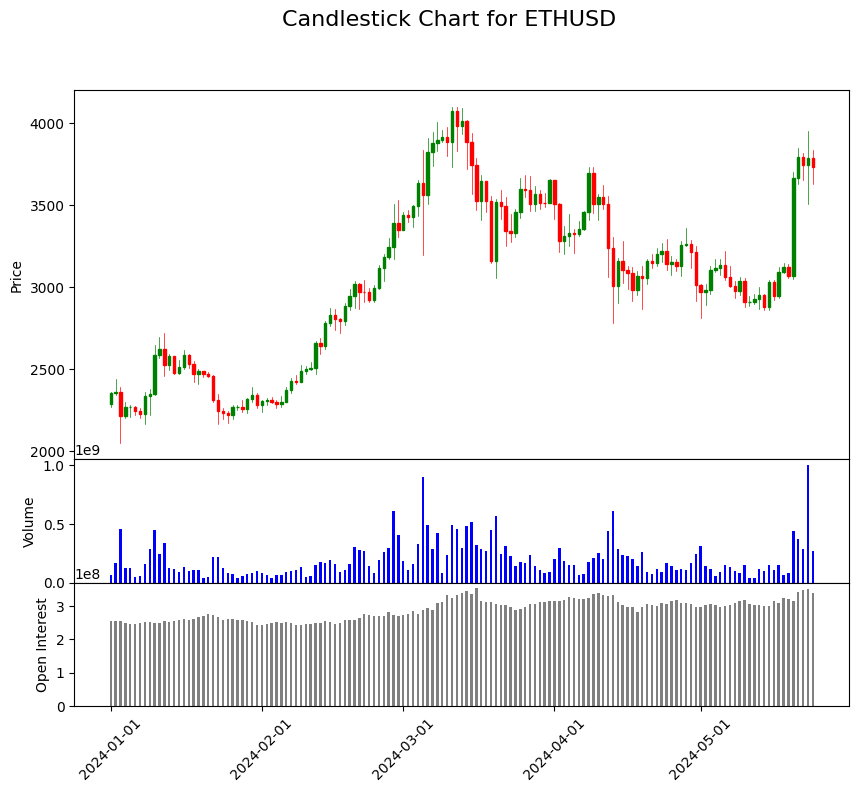

In [9]:
visualize_df_with_vol_oi(df_ETH, saving_path = "/Users/leonardoplacidi/Desktop/BacktestingTrade/Python4Finance/some_plots/ETH_chart.png")

# Ready for backtesting

In [3]:
import backtrader as bt
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, DateFormatter

Let's define a class for the trading strategy to use

setup backtest

Since I am using a personal csv dataset, I need to make sure that backtrader reads every column and is able to to use them as data_feeds

In [4]:
# Read CSV data into a Pandas DataFrame
data = pd.read_csv("/Users/leonardoplacidi/Desktop/BacktestingTrade/Python4Finance/data/Bybit_ETH_for_backtesting.csv", parse_dates=True)
data = data.rename(columns = {'startTime':'datetime'})
# Assuming your DataFrame is called 'data'
data['datetime'] = pd.to_datetime(data['datetime'])
# Set 'startTime' column as the index
#data.set_index('datetime', inplace=True)

# Ensure the 'startTime' column is set as the index and convert column names to lowercase
# Define the custom data feed class
class PandasData(bt.feeds.PandasData):
    # Add a 'volume', 'openInterest', and 'turnover' lines to the inherited ones from the base class
    lines = ('volume', 'openinterest', 'turnover')
    
    # Define parameters for the column names
    params = (
        ('datetime', 'datetime'),
        ('open', 'openPrice'),
        ('high', 'highPrice'),
        ('low', 'lowPrice'),
        ('close', 'closePrice'),
        ('volume', 'volume'),
        ('openinterest', 'openInterest'),
        ('turnover', 'turnover'),
    )

# Create an instance of the custom data feed
data_feed = PandasData(dataname=data, fromdate=datetime(2024, 1, 1),
    todate=datetime(2024, 5, 24))

In [5]:
data.head()

,datetime,openPrice,highPrice,lowPrice,closePrice,volume,turnover,symbol,openInterest
0,2024-05-24,3784.15,3832.05,3627.05,3728.60,268476729.0,72224.501005,ETHUSD,338357319.0
1,2024-05-23,3740.50,3951.15,3507.05,3784.15,998759848.0,263611.939310,ETHUSD,349971866.0
2,2024-05-22,3793.00,3815.35,3654.85,3740.50,287634099.0,76947.502901,ETHUSD,348212671.0
3,2024-05-21,3665.30,3844.85,3627.70,3793.00,375445948.0,100420.642724,ETHUSD,342281637.0
4,2024-05-20,3069.10,3699.90,3046.05,3665.30,439138274.0,130692.238330,ETHUSD,315706080.0


In [6]:
class SmaSignal(bt.Signal):
    params = (("period", 20), )

    def __init__(self):
        sma = bt.ind.SMA(period=self.p.period)
        self.lines.signal = self.data - sma


cerebro = bt.Cerebro(stdstats = False)
cerebro.adddata(data_feed)

cerebro.broker.setcash(1000.0)
#cerebro.add_signal(bt.SIGNAL_LONG, SmaSignal)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

class MySignalStrategy(bt.SignalStrategy):
    def __init__(self):
        self.signal_add(bt.SIGNAL_LONG, SmaSignal())
        

# Add the strategy to Cerebro
cerebro.addstrategy(MySignalStrategy)

# Run the strategy
cerebro.run()

In [7]:
print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}') 
cerebro.run() 
print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')

Starting Portfolio Value: 1000.00
Final Portfolio Value: 1000.00


/Users/leonardoplacidi/opt/anaconda3/envs/BT/lib/python3.9/site-packages/backtrader/plot/locator.py:184: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 14.
  warnings.warn('AutoDateLocator was unable to pick an '


AttributeError: type object 'AutoDateLocator' has no attribute 'DAY'

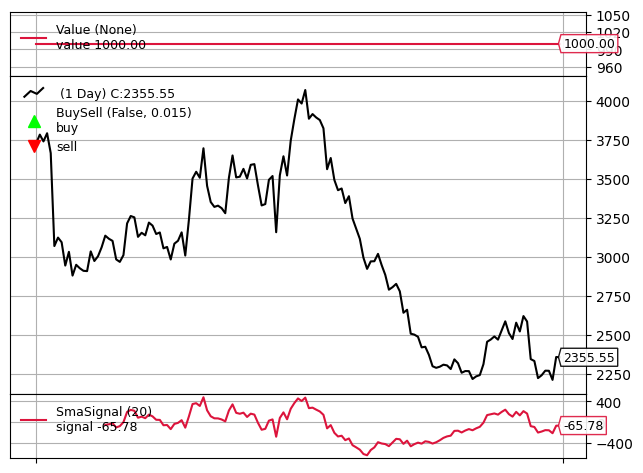

In [8]:
# Run the strategy
cerebro.run()

# Plotting
fig, ax = plt.subplots()
cerebro.plot(iplot=False, volume=False, ax=ax)

locator = AutoDateLocator()
locator.intervald[AutoDateLocator.DAY] = [1]  # Set this to your desired interval, e.g., [1] for daily, [7] for weekly
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))

plt.show()